In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

from pytorch_lightning import Trainer

In [4]:
from simple_relational_reasoning.datagen import object_fields
from simple_relational_reasoning.datagen import object_gen
from simple_relational_reasoning.models import MLPModel

In [5]:
float_cfgs = ( 
    object_gen.FieldConfig('x', 'float_position', ), 
    object_gen.FieldConfig('y', 'float_position', ), 
    object_gen.FieldConfig('color', 'one_hot', dict(n_types=4))
)


DISTANCE_THRESHOLD = 0.44  # approximately balanced for 16 objects


def float_adjacent_relation_evaluator(objects, field_slices, x_field_name='x', y_field_name='y', 
                                      distance_threshold=DISTANCE_THRESHOLD):
    # assert(x_field_name in field_slices)
    # assert(y_field_name in field_slices)
    object_positions = torch.cat((objects[:, field_slices[x_field_name]], objects[:, field_slices[y_field_name]]), dim=1).to(torch.float).unsqueeze(0)
    l2_distances = torch.cdist(object_positions, object_positions, 2)
    return l2_distances[l2_distances > 0].min() < distance_threshold
    
    
float_gen = object_gen.ObjectGenerator(16, float_cfgs, float_adjacent_relation_evaluator, 
                                 object_dtype=torch.float, label_dtype=torch.long,
                                # max_recursion_depth=100
                                )

X, y = float_gen(20)
X.shape, y.shape, y.sum()

(torch.Size([20, 16, 6]), torch.Size([20]), tensor(20))

In [11]:
X, y = gen(10000)
min_distances = []
for b in range(X.shape[0]):
    d = torch.cdist(X[b,:,:2], X[b,:,:2], 2)
    min_distances.append(d[d > 0].min().numpy())

(array([ 890., 2157., 2419., 2067., 1373.,  693.,  303.,   79.,   16.,
           3.]),
 array([0.00033779, 0.015593  , 0.0308482 , 0.04610341, 0.06135862,
        0.07661382, 0.09186903, 0.10712423, 0.12237944, 0.13763463,
        0.15288985], dtype=float32),
 <a list of 10 Patch objects>)

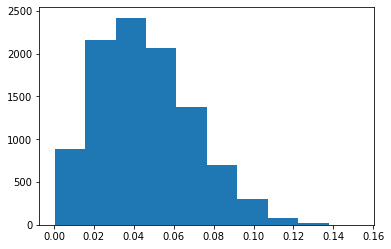

In [12]:
plt.hist(min_distances)

In [13]:
np.mean(min_distances), np.median(min_distances)

(0.045578454, 0.043074124)

In [28]:
t = torch.arange(4).unsqueeze(1)
o = t.repeat((1, 6))
b = o.unsqueeze(0).repeat((2, 1, 1))
B, N, K = b.shape

In [30]:
x_1 = b.unsqueeze(1).repeat((1, N, 1, 1))
x_2 = b.unsqueeze(2).repeat((1, 1, N, 1))

In [31]:
x_1.shape, x_2.shape

(torch.Size([2, 4, 4, 6]), torch.Size([2, 4, 4, 6]))

In [36]:
x = torch.cat([x_1, x_2], 3)

In [37]:
x.shape

torch.Size([2, 4, 4, 12])

In [39]:
x.sum(2).sum(1)

tensor([[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24],
        [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]])